# 离群点分析与异常值检测

## 数据集：wine_benchmarks

### 1.导库

In [1]:
import pandas as pd
from sklearn import metrics
from scipy import interpolate
import numpy as np
import os
import csv
import collections
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.abod import ABOD
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from pyod.models.loda import LODA
from pyod.models.lscp import LSCP
from sklearn.datasets import make_classification
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import precision_n_scores
import time
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('ggplot')

### 2.加载数据集

In [35]:
data = pd.read_csv('./wine_benchmarks/wine/meta_data/meta_wine.csv')

In [36]:
data.head()

,bench.id,benchnum,origin,mset,size,n.anom,n.norm,anomaly.rate.level,point.difficulty.level,clustering.algo,irrelevance.level,anomaly.rate,diff.mean,anom.diff.mean,norm.diff.mean,clusteredness.score,irrelevance.score,auc.ci.0.999,ap.ci.0.999
0,wine_benchmark_0001,1,regression,wine,3703,1334,2369,ar-0,pd-0,none,ir-0,0.360248,0.182961,0.261760,0.138589,-0.166763,0.0,0.524572,0.387671
1,wine_benchmark_0002,2,regression,wine,3703,1291,2412,ar-0,pd-0,none,ir-0,0.348636,0.183128,0.263461,0.140131,-0.143345,0.0,0.524823,0.376016
2,wine_benchmark_0003,3,regression,wine,3703,1350,2353,ar-0,pd-0,none,ir-0,0.364569,0.183230,0.260720,0.138770,-0.130568,0.0,0.524217,0.392040
3,wine_benchmark_0004,4,regression,wine,3703,1380,2323,ar-0,pd-0,none,ir-0,0.372671,0.184372,0.260923,0.138897,-0.121468,0.0,0.524031,0.400212
4,wine_benchmark_0005,5,regression,wine,3703,1334,2369,ar-0,pd-0,none,ir-0,0.360248,0.181841,0.260440,0.137581,-0.113667,0.0,0.524572,0.387671


In [37]:
ar = data['anomaly.rate']
ar_level = data['anomaly.rate.level']

In [38]:
#查看异常值等级
set(ar_level)

{'ar-0', 'ar-1', 'ar-2', 'ar-3', 'ar-4', 'ar-6'}

#### 各等级异常数据的比例和均值

In [39]:
data_dic = collections.defaultdict(list)
for item in data.iterrows():
    data_dic[item[1]['anomaly.rate.level']].append(item[1]['bench.id'])

In [40]:
data[['anomaly.rate','anomaly.rate.level']].groupby(['anomaly.rate.level']).count()

,anomaly.rate
anomaly.rate.level,
ar-0,300
ar-1,180
ar-2,190
ar-3,180
ar-4,180
ar-6,180


In [43]:
data[['anomaly.rate','anomaly.rate.level']].groupby(['anomaly.rate.level']).mean()

,anomaly.rate
anomaly.rate.level,
ar-0,0.412435
ar-1,0.001147
ar-2,0.005121
ar-3,0.010156
ar-4,0.050076
ar-6,0.100147


In [50]:
data_g = data[['anomaly.rate','anomaly.rate.level']].groupby(['anomaly.rate.level']).mean()
data_g

,anomaly.rate
anomaly.rate.level,
ar-0,0.412435
ar-1,0.001147
ar-2,0.005121
ar-3,0.010156
ar-4,0.050076
ar-6,0.100147


In [52]:
ar_mean = data_g['anomaly.rate'].tolist()

#### 数据集中，共有6个异常点比例等级

In [9]:
data = pd.read_csv('./wine_benchmarks/wine/benchmarks/wine_benchmark_0001.csv')

### 数据集中的特征

In [10]:
data.head(5)

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


### 选择特征，11个特征

In [11]:
data.columns[6:]

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

### 定义评估函数

In [12]:
def evaluation(y, y_scores, method):
    '''
    评估函数，y为groundtruth，y_scores为预测值，返回PR曲线，ROC曲线和AUC
    '''
    if isinstance(y_scores, dict):
        colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
        plt.figure(figsize=(7,7))
        i = 0
        for algo in y_scores:
            pre_scr = y_scores[algo]
            print(algo, pre_scr.shape)
            fpr_level = np.arange(0, 1, 0.01)
            fpr, tpr, threshold = metrics.roc_curve(y, pre_scr)
            interp = interpolate.interp1d(fpr, tpr)
            tpr_at_fpr = [interp(x) for x in fpr_level]
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i], label='%s ROC(area = %0.2f)' % (algo, roc_auc))
            i += 1
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Models Compare' + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.legend(loc="lower right")
    else:
        fpr_level = np.arange(0, 1, 0.01)
        fpr, tpr, threshold = metrics.roc_curve(y, y_scores)
        interp = interpolate.interp1d(fpr, tpr)
        tpr_at_fpr = [interp(x) for x in fpr_level]
        roc_auc = metrics.auc(fpr, tpr)
        precision, recall, _ = metrics.precision_recall_curve(y, y_scores)
        pr_auc = round(precision_n_scores(y, y_scores), ndigits=4)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(method + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, marker='.', label='precision @ rank n: %0.2f)' % pr_auc)
        plt.legend(loc="upper right")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(method + '-PR')
        plt.show()

### 对原始数据集进行抽样，每一个异常点level选择一个benchmark，共6个benchmark，并读取groundturth和特征属性

In [13]:
path = './wine_benchmarks/wine/benchmarks'
samples = []
for item in data_dic:
    samples.append(data_dic[item][0])
y = []
x_train = []
contam = 0
for sample in samples:
    p = os.path.join(path, sample+'.csv')
    data = pd.read_csv(p)
    data = data.dropna()
    for i in data.iterrows():
        # 0为正常，1为异常点
        if i[1][5] == 'anomaly':
            y.append(1)
            contam += 1
        else:
            y.append(0)
        x_train.append(list(i[1][6:17]))
x_train = np.array(x_train)
y = np.array(y)
contam /= len(y)

In [14]:
samples

['wine_benchmark_0001',
 'wine_benchmark_0301',
 'wine_benchmark_0601',
 'wine_benchmark_0901',
 'wine_benchmark_1201',
 'wine_benchmark_1501']

In [15]:
contam

0.08751529987760098

### 3.离群点检测

基于近邻(KNN，LOF)

Linear Model(PCA)

Outlier Ensembles(LODA)


In [22]:
algorithms = ['KNN', 'LOF', 'PCA', 'LODA']
all_scores = {}

### 比较不同算法

### 1.KNN

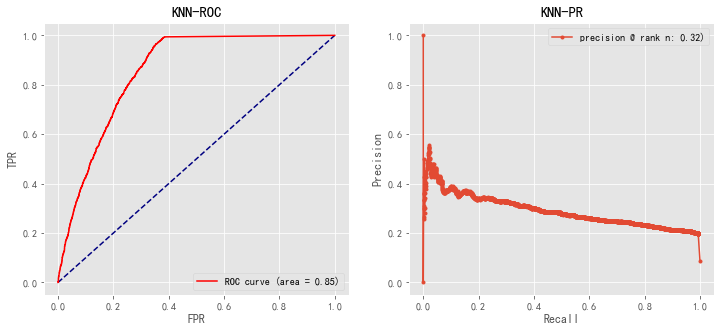

In [24]:
clf_name = 'KNN'
clf = KNN(n_neighbors=5, contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
knn_y_pred = clf.labels_  
knn_y_scores = clf.decision_scores_  
evaluation(y, knn_y_scores, clf_name)
all_scores['KNN'] = knn_y_scores

### 2.LOF

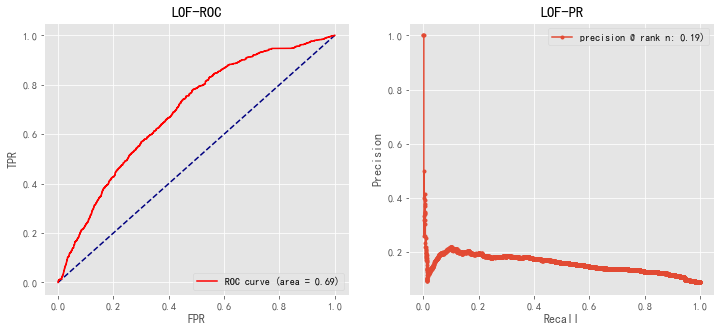

In [25]:
clf_name = 'LOF'
clf = LOF(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['LOF'] = y_scores 

### 3.PCA

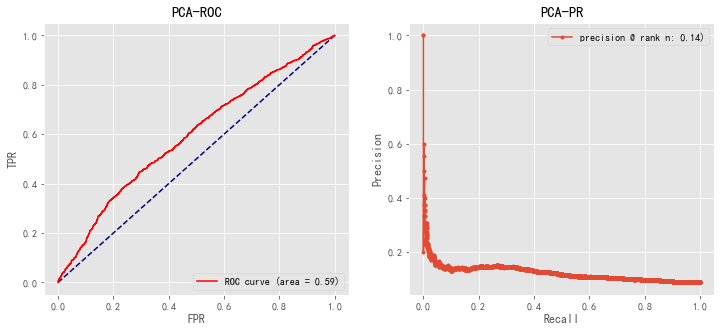

In [26]:
clf_name = 'PCA'
clf = PCA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['PCA'] = y_scores 

### 4.LODA

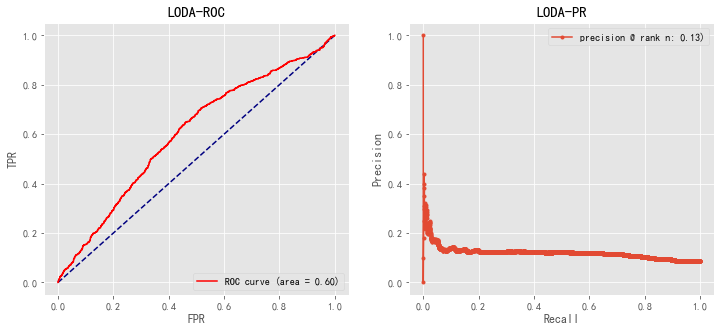

In [27]:
clf_name = 'LODA'
clf = LODA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['LODA'] = y_scores 

KNN (22876,)
LOF (22876,)
PCA (22876,)
LODA (22876,)


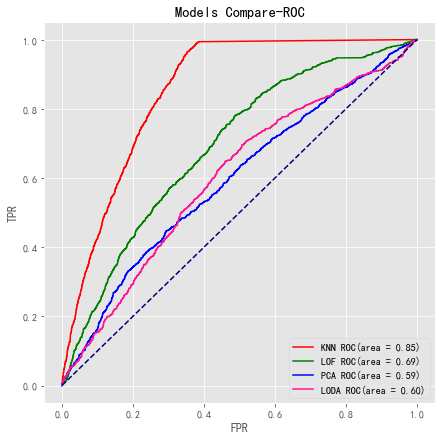

In [29]:
evaluation(y, all_scores, algorithms)

### 在同一抽样的benchmark下，KNN表现最好，ROC-AUC为0.85，PCA表现最差，为0.59

### 在所有样本上进行模型，输出auc到表格

In [30]:
results = collections.defaultdict(list)
with open('results_wine.csv', 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['benchmark_id', 'Model', 'ROC', 'precision at rank n', 'execution time'])
    for item in data_dic:
        for bench_id in data_dic[item]:
            x_item = []
            y_item = []
            contam = 0
            p = os.path.join(path, bench_id+'.csv')
            for i in pd.read_csv(p).iterrows():
                if i[1][5] == 'anomaly':
                    y_item.append(1)
                    contam += 1
                else:
                    y_item.append(0)
                x_item.append(list(i[1][6:17]))
            x_item = np.array(x_item)
            y_item = np.array(y_item)
            contam /= len(y_item)
            contam = min(0.5, contam)
            # 定义模型
            classifiers = {'KNN': KNN(contamination=contam),
                           'LOF': LOF(contamination=contam),
                           'PCA': PCA(contamination=contam),
                           'LODA': LODA(contamination=contam)
                          }
            for cls in classifiers:
                clf = classifiers[cls]
                t0 = time.time()
                x_item = standardizer(x_item)
                clf.fit(x_item)
                y_scores = clf.decision_function(x_item)
                t1 = time.time()
                duration = round(t1 - t0, ndigits=4)

                roc = round(roc_auc_score(y_item, y_scores), ndigits=4)
                prn = round(precision_n_scores(y_item, y_scores), ndigits=4)
                results[cls].append(roc)
                
                print('benchmark id:{bench_id}, model:{clf_name}, ROC:{roc}, precision @ rank n:{prn}, '
                      'execution time: {duration}s'.format(
                    bench_id=bench_id, clf_name=cls, roc=roc, prn=prn, duration=duration))

                csv_writer.writerow([bench_id, cls, roc, prn, duration])

f.close()

benchmark id:wine_benchmark_0001, model:KNN, ROC:0.5448, precision @ rank n:0.41, execution time: 0.5416s
benchmark id:wine_benchmark_0001, model:LOF, ROC:0.55, precision @ rank n:0.4063, execution time: 0.4717s
benchmark id:wine_benchmark_0001, model:PCA, ROC:0.5418, precision @ rank n:0.4171, execution time: 0.0069s
benchmark id:wine_benchmark_0001, model:LODA, ROC:0.5572, precision @ rank n:0.4048, execution time: 0.056s
benchmark id:wine_benchmark_0002, model:KNN, ROC:0.5468, precision @ rank n:0.3961, execution time: 0.5416s
benchmark id:wine_benchmark_0002, model:LOF, ROC:0.5659, precision @ rank n:0.4028, execution time: 0.4915s
benchmark id:wine_benchmark_0002, model:PCA, ROC:0.5408, precision @ rank n:0.3943, execution time: 0.0069s
benchmark id:wine_benchmark_0002, model:LODA, ROC:0.576, precision @ rank n:0.4186, execution time: 0.0556s
benchmark id:wine_benchmark_0003, model:KNN, ROC:0.5582, precision @ rank n:0.4163, execution time: 0.5064s
benchmark id:wine_benchmark_0003

benchmark id:wine_benchmark_0020, model:KNN, ROC:0.5416, precision @ rank n:0.4095, execution time: 0.6433s
benchmark id:wine_benchmark_0020, model:LOF, ROC:0.5492, precision @ rank n:0.4065, execution time: 0.5466s
benchmark id:wine_benchmark_0020, model:PCA, ROC:0.5398, precision @ rank n:0.4138, execution time: 0.0064s
benchmark id:wine_benchmark_0020, model:LODA, ROC:0.4384, precision @ rank n:0.3127, execution time: 0.065s
benchmark id:wine_benchmark_0021, model:KNN, ROC:0.5558, precision @ rank n:0.4462, execution time: 0.6562s
benchmark id:wine_benchmark_0021, model:LOF, ROC:0.5533, precision @ rank n:0.4225, execution time: 0.5044s
benchmark id:wine_benchmark_0021, model:PCA, ROC:0.5362, precision @ rank n:0.424, execution time: 0.01s
benchmark id:wine_benchmark_0021, model:LODA, ROC:0.6155, precision @ rank n:0.4598, execution time: 0.0645s
benchmark id:wine_benchmark_0022, model:KNN, ROC:0.5432, precision @ rank n:0.4137, execution time: 0.6433s
benchmark id:wine_benchmark_00

benchmark id:wine_benchmark_0039, model:KNN, ROC:0.55, precision @ rank n:0.4114, execution time: 0.5972s
benchmark id:wine_benchmark_0039, model:LOF, ROC:0.5554, precision @ rank n:0.4114, execution time: 0.5218s
benchmark id:wine_benchmark_0039, model:PCA, ROC:0.5454, precision @ rank n:0.418, execution time: 0.0069s
benchmark id:wine_benchmark_0039, model:LODA, ROC:0.5834, precision @ rank n:0.4328, execution time: 0.0644s
benchmark id:wine_benchmark_0040, model:KNN, ROC:0.55, precision @ rank n:0.4113, execution time: 0.565s
benchmark id:wine_benchmark_0040, model:LOF, ROC:0.558, precision @ rank n:0.4157, execution time: 0.5005s
benchmark id:wine_benchmark_0040, model:PCA, ROC:0.5536, precision @ rank n:0.4297, execution time: 0.006s
benchmark id:wine_benchmark_0040, model:LODA, ROC:0.5875, precision @ rank n:0.4603, execution time: 0.065s
benchmark id:wine_benchmark_0041, model:KNN, ROC:0.5347, precision @ rank n:0.3901, execution time: 0.5779s
benchmark id:wine_benchmark_0041, m

benchmark id:wine_benchmark_0077, model:KNN, ROC:0.5476, precision @ rank n:0.4298, execution time: 0.6964s
benchmark id:wine_benchmark_0077, model:LOF, ROC:0.5664, precision @ rank n:0.4333, execution time: 0.5644s
benchmark id:wine_benchmark_0077, model:PCA, ROC:0.5531, precision @ rank n:0.4376, execution time: 0.0079s
benchmark id:wine_benchmark_0077, model:LODA, ROC:0.615, precision @ rank n:0.4809, execution time: 0.068s
benchmark id:wine_benchmark_0078, model:KNN, ROC:0.5421, precision @ rank n:0.4157, execution time: 0.743s
benchmark id:wine_benchmark_0078, model:LOF, ROC:0.5576, precision @ rank n:0.412, execution time: 0.6091s
benchmark id:wine_benchmark_0078, model:PCA, ROC:0.55, precision @ rank n:0.4216, execution time: 0.0069s
benchmark id:wine_benchmark_0078, model:LODA, ROC:0.5286, precision @ rank n:0.3966, execution time: 0.0699s
benchmark id:wine_benchmark_0079, model:KNN, ROC:0.5685, precision @ rank n:0.4398, execution time: 0.6746s
benchmark id:wine_benchmark_0079

benchmark id:wine_benchmark_0096, model:LOF, ROC:0.5592, precision @ rank n:0.4184, execution time: 0.5143s
benchmark id:wine_benchmark_0096, model:PCA, ROC:0.5577, precision @ rank n:0.436, execution time: 0.0074s
benchmark id:wine_benchmark_0096, model:LODA, ROC:0.555, precision @ rank n:0.4287, execution time: 0.0655s
benchmark id:wine_benchmark_0097, model:KNN, ROC:0.5603, precision @ rank n:0.4253, execution time: 0.6096s
benchmark id:wine_benchmark_0097, model:LOF, ROC:0.5654, precision @ rank n:0.4268, execution time: 0.5322s
benchmark id:wine_benchmark_0097, model:PCA, ROC:0.5625, precision @ rank n:0.4327, execution time: 0.0079s
benchmark id:wine_benchmark_0097, model:LODA, ROC:0.6557, precision @ rank n:0.5033, execution time: 0.0709s
benchmark id:wine_benchmark_0098, model:KNN, ROC:0.5497, precision @ rank n:0.4255, execution time: 0.9687s
benchmark id:wine_benchmark_0098, model:LOF, ROC:0.5674, precision @ rank n:0.4219, execution time: 0.8184s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_0115, model:LOF, ROC:0.5554, precision @ rank n:0.4122, execution time: 0.5148s
benchmark id:wine_benchmark_0115, model:PCA, ROC:0.532, precision @ rank n:0.4073, execution time: 0.0084s
benchmark id:wine_benchmark_0115, model:LODA, ROC:0.4645, precision @ rank n:0.3698, execution time: 0.062s
benchmark id:wine_benchmark_0116, model:KNN, ROC:0.5379, precision @ rank n:0.4025, execution time: 0.5863s
benchmark id:wine_benchmark_0116, model:LOF, ROC:0.5478, precision @ rank n:0.4069, execution time: 0.5272s
benchmark id:wine_benchmark_0116, model:PCA, ROC:0.5316, precision @ rank n:0.4077, execution time: 0.0064s
benchmark id:wine_benchmark_0116, model:LODA, ROC:0.5876, precision @ rank n:0.4437, execution time: 0.0655s
benchmark id:wine_benchmark_0117, model:KNN, ROC:0.524, precision @ rank n:0.404, execution time: 0.5957s
benchmark id:wine_benchmark_0117, model:LOF, ROC:0.5371, precision @ rank n:0.4059, execution time: 0.5397s
benchmark id:wine_benchmark_01

benchmark id:wine_benchmark_0134, model:LOF, ROC:0.5477, precision @ rank n:0.4195, execution time: 0.5272s
benchmark id:wine_benchmark_0134, model:PCA, ROC:0.5405, precision @ rank n:0.4217, execution time: 0.0069s
benchmark id:wine_benchmark_0134, model:LODA, ROC:0.5546, precision @ rank n:0.4281, execution time: 0.062s
benchmark id:wine_benchmark_0135, model:KNN, ROC:0.5426, precision @ rank n:0.4024, execution time: 0.62s
benchmark id:wine_benchmark_0135, model:LOF, ROC:0.5509, precision @ rank n:0.4024, execution time: 0.5272s
benchmark id:wine_benchmark_0135, model:PCA, ROC:0.5458, precision @ rank n:0.4174, execution time: 0.006s
benchmark id:wine_benchmark_0135, model:LODA, ROC:0.5224, precision @ rank n:0.3997, execution time: 0.063s
benchmark id:wine_benchmark_0136, model:KNN, ROC:0.5481, precision @ rank n:0.4267, execution time: 0.5372s
benchmark id:wine_benchmark_0136, model:LOF, ROC:0.5668, precision @ rank n:0.4277, execution time: 0.4618s
benchmark id:wine_benchmark_013

benchmark id:wine_benchmark_0153, model:LOF, ROC:0.5583, precision @ rank n:0.4161, execution time: 0.5406s
benchmark id:wine_benchmark_0153, model:PCA, ROC:0.5619, precision @ rank n:0.4236, execution time: 0.0074s
benchmark id:wine_benchmark_0153, model:LODA, ROC:0.6047, precision @ rank n:0.453, execution time: 0.0684s
benchmark id:wine_benchmark_0154, model:KNN, ROC:0.5496, precision @ rank n:0.4078, execution time: 0.6012s
benchmark id:wine_benchmark_0154, model:LOF, ROC:0.5463, precision @ rank n:0.4071, execution time: 0.5371s
benchmark id:wine_benchmark_0154, model:PCA, ROC:0.5455, precision @ rank n:0.4284, execution time: 0.007s
benchmark id:wine_benchmark_0154, model:LODA, ROC:0.555, precision @ rank n:0.4166, execution time: 0.0625s
benchmark id:wine_benchmark_0155, model:KNN, ROC:0.5429, precision @ rank n:0.4143, execution time: 0.5888s
benchmark id:wine_benchmark_0155, model:LOF, ROC:0.5432, precision @ rank n:0.4164, execution time: 0.562s
benchmark id:wine_benchmark_01

benchmark id:wine_benchmark_0172, model:LOF, ROC:0.5491, precision @ rank n:0.4133, execution time: 0.5089s
benchmark id:wine_benchmark_0172, model:PCA, ROC:0.5223, precision @ rank n:0.3955, execution time: 0.0069s
benchmark id:wine_benchmark_0172, model:LODA, ROC:0.5306, precision @ rank n:0.3921, execution time: 0.065s
benchmark id:wine_benchmark_0173, model:KNN, ROC:0.5266, precision @ rank n:0.408, execution time: 0.5773s
benchmark id:wine_benchmark_0173, model:LOF, ROC:0.5426, precision @ rank n:0.4102, execution time: 0.493s
benchmark id:wine_benchmark_0173, model:PCA, ROC:0.5141, precision @ rank n:0.3978, execution time: 0.006s
benchmark id:wine_benchmark_0173, model:LODA, ROC:0.5406, precision @ rank n:0.4313, execution time: 0.062s
benchmark id:wine_benchmark_0174, model:KNN, ROC:0.5286, precision @ rank n:0.4013, execution time: 0.5803s
benchmark id:wine_benchmark_0174, model:LOF, ROC:0.5464, precision @ rank n:0.4031, execution time: 0.5044s
benchmark id:wine_benchmark_017

benchmark id:wine_benchmark_0191, model:LOF, ROC:0.5136, precision @ rank n:0.4599, execution time: 0.242s
benchmark id:wine_benchmark_0191, model:PCA, ROC:0.4745, precision @ rank n:0.431, execution time: 0.0059s
benchmark id:wine_benchmark_0191, model:LODA, ROC:0.4856, precision @ rank n:0.4338, execution time: 0.0525s
benchmark id:wine_benchmark_0192, model:KNN, ROC:0.4943, precision @ rank n:0.4489, execution time: 0.3145s
benchmark id:wine_benchmark_0192, model:LOF, ROC:0.5136, precision @ rank n:0.4656, execution time: 0.2445s
benchmark id:wine_benchmark_0192, model:PCA, ROC:0.4969, precision @ rank n:0.4527, execution time: 0.0055s
benchmark id:wine_benchmark_0192, model:LODA, ROC:0.5219, precision @ rank n:0.4775, execution time: 0.0491s
benchmark id:wine_benchmark_0193, model:KNN, ROC:0.4983, precision @ rank n:0.4382, execution time: 0.3145s
benchmark id:wine_benchmark_0193, model:LOF, ROC:0.5149, precision @ rank n:0.4607, execution time: 0.2386s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_0210, model:LOF, ROC:0.5019, precision @ rank n:0.4575, execution time: 0.2366s
benchmark id:wine_benchmark_0210, model:PCA, ROC:0.4867, precision @ rank n:0.4455, execution time: 0.0045s
benchmark id:wine_benchmark_0210, model:LODA, ROC:0.4636, precision @ rank n:0.4261, execution time: 0.0491s
benchmark id:wine_benchmark_0211, model:KNN, ROC:0.4923, precision @ rank n:0.4317, execution time: 0.3145s
benchmark id:wine_benchmark_0211, model:LOF, ROC:0.5097, precision @ rank n:0.4552, execution time: 0.2296s
benchmark id:wine_benchmark_0211, model:PCA, ROC:0.4828, precision @ rank n:0.443, execution time: 0.005s
benchmark id:wine_benchmark_0211, model:LODA, ROC:0.5316, precision @ rank n:0.4736, execution time: 0.0471s
benchmark id:wine_benchmark_0212, model:KNN, ROC:0.4966, precision @ rank n:0.4376, execution time: 0.3075s
benchmark id:wine_benchmark_0212, model:LOF, ROC:0.5098, precision @ rank n:0.4471, execution time: 0.2336s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_0230, model:KNN, ROC:0.4978, precision @ rank n:0.4544, execution time: 0.3159s
benchmark id:wine_benchmark_0230, model:LOF, ROC:0.5069, precision @ rank n:0.4635, execution time: 0.2445s
benchmark id:wine_benchmark_0230, model:PCA, ROC:0.4764, precision @ rank n:0.4425, execution time: 0.005s
benchmark id:wine_benchmark_0230, model:LODA, ROC:0.5115, precision @ rank n:0.4854, execution time: 0.0521s
benchmark id:wine_benchmark_0231, model:KNN, ROC:0.5009, precision @ rank n:0.4434, execution time: 0.3804s
benchmark id:wine_benchmark_0231, model:LOF, ROC:0.5149, precision @ rank n:0.4557, execution time: 0.2763s
benchmark id:wine_benchmark_0231, model:PCA, ROC:0.4808, precision @ rank n:0.4249, execution time: 0.0064s
benchmark id:wine_benchmark_0231, model:LODA, ROC:0.4874, precision @ rank n:0.4292, execution time: 0.0575s
benchmark id:wine_benchmark_0232, model:KNN, ROC:0.4873, precision @ rank n:0.4236, execution time: 0.3234s
benchmark id:wine_benchmark

benchmark id:wine_benchmark_0250, model:KNN, ROC:0.5489, precision @ rank n:0.5569, execution time: 0.1106s
benchmark id:wine_benchmark_0250, model:LOF, ROC:0.5216, precision @ rank n:0.5289, execution time: 0.0591s
benchmark id:wine_benchmark_0250, model:PCA, ROC:0.4814, precision @ rank n:0.501, execution time: 0.0034s
benchmark id:wine_benchmark_0250, model:LODA, ROC:0.4569, precision @ rank n:0.4731, execution time: 0.0402s
benchmark id:wine_benchmark_0251, model:KNN, ROC:0.5524, precision @ rank n:0.5293, execution time: 0.1091s
benchmark id:wine_benchmark_0251, model:LOF, ROC:0.5142, precision @ rank n:0.5, execution time: 0.058s
benchmark id:wine_benchmark_0251, model:PCA, ROC:0.4901, precision @ rank n:0.4874, execution time: 0.003s
benchmark id:wine_benchmark_0251, model:LODA, ROC:0.4558, precision @ rank n:0.454, execution time: 0.0397s
benchmark id:wine_benchmark_0252, model:KNN, ROC:0.5349, precision @ rank n:0.5467, execution time: 0.1171s
benchmark id:wine_benchmark_0252,

benchmark id:wine_benchmark_0270, model:KNN, ROC:0.5478, precision @ rank n:0.5207, execution time: 0.1091s
benchmark id:wine_benchmark_0270, model:LOF, ROC:0.5132, precision @ rank n:0.4876, execution time: 0.0581s
benchmark id:wine_benchmark_0270, model:PCA, ROC:0.475, precision @ rank n:0.4772, execution time: 0.003s
benchmark id:wine_benchmark_0270, model:LODA, ROC:0.4764, precision @ rank n:0.473, execution time: 0.0352s
benchmark id:wine_benchmark_0271, model:KNN, ROC:0.5498, precision @ rank n:0.5725, execution time: 0.1072s
benchmark id:wine_benchmark_0271, model:LOF, ROC:0.5277, precision @ rank n:0.5319, execution time: 0.0625s
benchmark id:wine_benchmark_0271, model:PCA, ROC:0.4952, precision @ rank n:0.5242, execution time: 0.003s
benchmark id:wine_benchmark_0271, model:LODA, ROC:0.5112, precision @ rank n:0.5338, execution time: 0.0397s
benchmark id:wine_benchmark_0272, model:KNN, ROC:0.5505, precision @ rank n:0.5411, execution time: 0.1111s
benchmark id:wine_benchmark_02

benchmark id:wine_benchmark_0290, model:KNN, ROC:0.5439, precision @ rank n:0.5386, execution time: 0.0933s
benchmark id:wine_benchmark_0290, model:LOF, ROC:0.5172, precision @ rank n:0.5224, execution time: 0.0451s
benchmark id:wine_benchmark_0290, model:PCA, ROC:0.4794, precision @ rank n:0.4898, execution time: 0.003s
benchmark id:wine_benchmark_0290, model:LODA, ROC:0.4478, precision @ rank n:0.4736, execution time: 0.0407s
benchmark id:wine_benchmark_0291, model:KNN, ROC:0.5578, precision @ rank n:0.5576, execution time: 0.1116s
benchmark id:wine_benchmark_0291, model:LOF, ROC:0.53, precision @ rank n:0.5293, execution time: 0.06s
benchmark id:wine_benchmark_0291, model:PCA, ROC:0.487, precision @ rank n:0.499, execution time: 0.0039s
benchmark id:wine_benchmark_0291, model:LODA, ROC:0.4642, precision @ rank n:0.4727, execution time: 0.0352s
benchmark id:wine_benchmark_0292, model:KNN, ROC:0.5451, precision @ rank n:0.5462, execution time: 0.1061s
benchmark id:wine_benchmark_0292,

benchmark id:wine_benchmark_0310, model:KNN, ROC:0.5669, precision @ rank n:0.0, execution time: 0.6016s
benchmark id:wine_benchmark_0310, model:LOF, ROC:0.5617, precision @ rank n:0.0, execution time: 0.5173s
benchmark id:wine_benchmark_0310, model:PCA, ROC:0.5932, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0310, model:LODA, ROC:0.6827, precision @ rank n:0.0, execution time: 0.0709s
benchmark id:wine_benchmark_0311, model:KNN, ROC:0.7038, precision @ rank n:0.0, execution time: 0.8214s
benchmark id:wine_benchmark_0311, model:LOF, ROC:0.527, precision @ rank n:0.0, execution time: 0.6071s
benchmark id:wine_benchmark_0311, model:PCA, ROC:0.5923, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wine_benchmark_0311, model:LODA, ROC:0.6864, precision @ rank n:0.0, execution time: 0.0803s
benchmark id:wine_benchmark_0312, model:KNN, ROC:0.6371, precision @ rank n:0.0, execution time: 0.621s
benchmark id:wine_benchmark_0312, model:LOF, ROC:0.6899

benchmark id:wine_benchmark_0330, model:KNN, ROC:0.6681, precision @ rank n:0.3333, execution time: 0.6414s
benchmark id:wine_benchmark_0330, model:LOF, ROC:0.724, precision @ rank n:0.25, execution time: 0.5188s
benchmark id:wine_benchmark_0330, model:PCA, ROC:0.7384, precision @ rank n:0.25, execution time: 0.0069s
benchmark id:wine_benchmark_0330, model:LODA, ROC:0.7269, precision @ rank n:0.0, execution time: 0.0694s
benchmark id:wine_benchmark_0331, model:KNN, ROC:0.9566, precision @ rank n:0.6667, execution time: 0.6393s
benchmark id:wine_benchmark_0331, model:LOF, ROC:0.9544, precision @ rank n:0.6667, execution time: 0.5208s
benchmark id:wine_benchmark_0331, model:PCA, ROC:0.9741, precision @ rank n:0.5, execution time: 0.0074s
benchmark id:wine_benchmark_0331, model:LODA, ROC:0.9171, precision @ rank n:0.25, execution time: 0.0625s
benchmark id:wine_benchmark_0332, model:KNN, ROC:0.7017, precision @ rank n:0.25, execution time: 0.5803s
benchmark id:wine_benchmark_0332, model:L

benchmark id:wine_benchmark_0350, model:KNN, ROC:0.5687, precision @ rank n:0.0, execution time: 0.5441s
benchmark id:wine_benchmark_0350, model:LOF, ROC:0.6094, precision @ rank n:0.0, execution time: 0.4727s
benchmark id:wine_benchmark_0350, model:PCA, ROC:0.655, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0350, model:LODA, ROC:0.638, precision @ rank n:0.0, execution time: 0.0645s
benchmark id:wine_benchmark_0351, model:KNN, ROC:0.4655, precision @ rank n:0.0, execution time: 0.5356s
benchmark id:wine_benchmark_0351, model:LOF, ROC:0.4812, precision @ rank n:0.0, execution time: 0.4727s
benchmark id:wine_benchmark_0351, model:PCA, ROC:0.2893, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0351, model:LODA, ROC:0.2853, precision @ rank n:0.0, execution time: 0.0635s
benchmark id:wine_benchmark_0352, model:KNN, ROC:0.3122, precision @ rank n:0.0, execution time: 0.5506s
benchmark id:wine_benchmark_0352, model:LOF, ROC:0.2137

benchmark id:wine_benchmark_0370, model:KNN, ROC:0.8124, precision @ rank n:0.0, execution time: 0.5347s
benchmark id:wine_benchmark_0370, model:LOF, ROC:0.728, precision @ rank n:0.0, execution time: 0.4667s
benchmark id:wine_benchmark_0370, model:PCA, ROC:0.8016, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0370, model:LODA, ROC:0.8021, precision @ rank n:0.0, execution time: 0.064s
benchmark id:wine_benchmark_0371, model:KNN, ROC:0.8367, precision @ rank n:0.0, execution time: 0.5481s
benchmark id:wine_benchmark_0371, model:LOF, ROC:0.7996, precision @ rank n:0.0, execution time: 0.4677s
benchmark id:wine_benchmark_0371, model:PCA, ROC:0.7032, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wine_benchmark_0371, model:LODA, ROC:0.6474, precision @ rank n:0.0, execution time: 0.0665s
benchmark id:wine_benchmark_0372, model:KNN, ROC:0.5278, precision @ rank n:0.0, execution time: 0.5466s
benchmark id:wine_benchmark_0372, model:LOF, ROC:0.539,

benchmark id:wine_benchmark_0390, model:KNN, ROC:0.6286, precision @ rank n:0.0, execution time: 0.5892s
benchmark id:wine_benchmark_0390, model:LOF, ROC:0.8587, precision @ rank n:0.0, execution time: 0.4856s
benchmark id:wine_benchmark_0390, model:PCA, ROC:0.8034, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0390, model:LODA, ROC:0.6839, precision @ rank n:0.0, execution time: 0.0659s
benchmark id:wine_benchmark_0391, model:KNN, ROC:0.9398, precision @ rank n:0.0, execution time: 0.688s
benchmark id:wine_benchmark_0391, model:LOF, ROC:0.8629, precision @ rank n:0.0, execution time: 0.5297s
benchmark id:wine_benchmark_0391, model:PCA, ROC:0.7967, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0391, model:LODA, ROC:0.8032, precision @ rank n:0.0, execution time: 0.066s
benchmark id:wine_benchmark_0392, model:KNN, ROC:0.8931, precision @ rank n:0.0, execution time: 0.6498s
benchmark id:wine_benchmark_0392, model:LOF, ROC:0.9006

benchmark id:wine_benchmark_0410, model:KNN, ROC:0.8997, precision @ rank n:0.0, execution time: 0.6066s
benchmark id:wine_benchmark_0410, model:LOF, ROC:0.8441, precision @ rank n:0.0, execution time: 0.5034s
benchmark id:wine_benchmark_0410, model:PCA, ROC:0.5886, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_0410, model:LODA, ROC:0.6133, precision @ rank n:0.0, execution time: 0.0739s
benchmark id:wine_benchmark_0411, model:KNN, ROC:0.457, precision @ rank n:0.0, execution time: 0.618s
benchmark id:wine_benchmark_0411, model:LOF, ROC:0.5334, precision @ rank n:0.0, execution time: 0.5332s
benchmark id:wine_benchmark_0411, model:PCA, ROC:0.2762, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_0411, model:LODA, ROC:0.5175, precision @ rank n:0.0, execution time: 0.0699s
benchmark id:wine_benchmark_0412, model:KNN, ROC:0.793, precision @ rank n:0.0, execution time: 0.5709s
benchmark id:wine_benchmark_0412, model:LOF, ROC:0.8104,

benchmark id:wine_benchmark_0430, model:KNN, ROC:0.3843, precision @ rank n:0.0, execution time: 0.495s
benchmark id:wine_benchmark_0430, model:LOF, ROC:0.3901, precision @ rank n:0.0, execution time: 0.4137s
benchmark id:wine_benchmark_0430, model:PCA, ROC:0.4361, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wine_benchmark_0430, model:LODA, ROC:0.4451, precision @ rank n:0.0, execution time: 0.0724s
benchmark id:wine_benchmark_0431, model:KNN, ROC:0.5888, precision @ rank n:0.0, execution time: 0.4915s
benchmark id:wine_benchmark_0431, model:LOF, ROC:0.6234, precision @ rank n:0.0, execution time: 0.4062s
benchmark id:wine_benchmark_0431, model:PCA, ROC:0.6228, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0431, model:LODA, ROC:0.7599, precision @ rank n:0.25, execution time: 0.0625s
benchmark id:wine_benchmark_0432, model:KNN, ROC:0.6839, precision @ rank n:0.0, execution time: 0.5s
benchmark id:wine_benchmark_0432, model:LOF, ROC:0.53, p

benchmark id:wine_benchmark_0450, model:KNN, ROC:0.8328, precision @ rank n:0.0, execution time: 0.4826s
benchmark id:wine_benchmark_0450, model:LOF, ROC:0.8128, precision @ rank n:0.0, execution time: 0.3988s
benchmark id:wine_benchmark_0450, model:PCA, ROC:0.761, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wine_benchmark_0450, model:LODA, ROC:0.7474, precision @ rank n:0.0, execution time: 0.063s
benchmark id:wine_benchmark_0451, model:KNN, ROC:0.3664, precision @ rank n:0.3333, execution time: 0.49s
benchmark id:wine_benchmark_0451, model:LOF, ROC:0.3627, precision @ rank n:0.25, execution time: 0.4638s
benchmark id:wine_benchmark_0451, model:PCA, ROC:0.4304, precision @ rank n:0.25, execution time: 0.0064s
benchmark id:wine_benchmark_0451, model:LODA, ROC:0.5561, precision @ rank n:0.25, execution time: 0.0699s
benchmark id:wine_benchmark_0452, model:KNN, ROC:0.7167, precision @ rank n:0.0, execution time: 0.4781s
benchmark id:wine_benchmark_0452, model:LOF, ROC:0.

benchmark id:wine_benchmark_0470, model:KNN, ROC:0.9959, precision @ rank n:0.0, execution time: 0.4613s
benchmark id:wine_benchmark_0470, model:LOF, ROC:0.9402, precision @ rank n:0.0, execution time: 0.3933s
benchmark id:wine_benchmark_0470, model:PCA, ROC:0.9977, precision @ rank n:0.25, execution time: 0.006s
benchmark id:wine_benchmark_0470, model:LODA, ROC:0.9941, precision @ rank n:0.25, execution time: 0.0585s
benchmark id:wine_benchmark_0471, model:KNN, ROC:0.3792, precision @ rank n:0.0, execution time: 0.4692s
benchmark id:wine_benchmark_0471, model:LOF, ROC:0.4351, precision @ rank n:0.0, execution time: 0.3983s
benchmark id:wine_benchmark_0471, model:PCA, ROC:0.3271, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0471, model:LODA, ROC:0.4781, precision @ rank n:0.0, execution time: 0.0694s
benchmark id:wine_benchmark_0472, model:KNN, ROC:0.7069, precision @ rank n:0.0, execution time: 0.4836s
benchmark id:wine_benchmark_0472, model:LOF, ROC:0.6

benchmark id:wine_benchmark_0610, model:KNN, ROC:0.7078, precision @ rank n:0.0, execution time: 0.5823s
benchmark id:wine_benchmark_0610, model:LOF, ROC:0.668, precision @ rank n:0.0526, execution time: 0.5099s
benchmark id:wine_benchmark_0610, model:PCA, ROC:0.6673, precision @ rank n:0.0526, execution time: 0.0074s
benchmark id:wine_benchmark_0610, model:LODA, ROC:0.5918, precision @ rank n:0.0526, execution time: 0.0704s
benchmark id:wine_benchmark_0611, model:KNN, ROC:0.7245, precision @ rank n:0.0, execution time: 0.6051s
benchmark id:wine_benchmark_0611, model:LOF, ROC:0.6426, precision @ rank n:0.1111, execution time: 0.5704s
benchmark id:wine_benchmark_0611, model:PCA, ROC:0.6782, precision @ rank n:0.0556, execution time: 0.0069s
benchmark id:wine_benchmark_0611, model:LODA, ROC:0.7076, precision @ rank n:0.0, execution time: 0.0714s
benchmark id:wine_benchmark_0612, model:KNN, ROC:0.6829, precision @ rank n:0.0, execution time: 0.5773s
benchmark id:wine_benchmark_0612, model

benchmark id:wine_benchmark_0629, model:LOF, ROC:0.5952, precision @ rank n:0.0, execution time: 0.5396s
benchmark id:wine_benchmark_0629, model:PCA, ROC:0.6612, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0629, model:LODA, ROC:0.6592, precision @ rank n:0.0, execution time: 0.0655s
benchmark id:wine_benchmark_0630, model:KNN, ROC:0.6608, precision @ rank n:0.0, execution time: 0.6041s
benchmark id:wine_benchmark_0630, model:LOF, ROC:0.6784, precision @ rank n:0.0526, execution time: 0.5158s
benchmark id:wine_benchmark_0630, model:PCA, ROC:0.651, precision @ rank n:0.0, execution time: 0.0104s
benchmark id:wine_benchmark_0630, model:LODA, ROC:0.6204, precision @ rank n:0.0, execution time: 0.0719s
benchmark id:wine_benchmark_0631, model:KNN, ROC:0.6663, precision @ rank n:0.0526, execution time: 0.6245s
benchmark id:wine_benchmark_0631, model:LOF, ROC:0.6216, precision @ rank n:0.0526, execution time: 0.5684s
benchmark id:wine_benchmark_0631, model:PCA, 

benchmark id:wine_benchmark_0649, model:KNN, ROC:0.5969, precision @ rank n:0.0, execution time: 0.5897s
benchmark id:wine_benchmark_0649, model:LOF, ROC:0.5944, precision @ rank n:0.0526, execution time: 0.5312s
benchmark id:wine_benchmark_0649, model:PCA, ROC:0.4716, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_0649, model:LODA, ROC:0.4472, precision @ rank n:0.0, execution time: 0.0714s
benchmark id:wine_benchmark_0650, model:KNN, ROC:0.6834, precision @ rank n:0.0, execution time: 0.615s
benchmark id:wine_benchmark_0650, model:LOF, ROC:0.6451, precision @ rank n:0.0556, execution time: 0.5273s
benchmark id:wine_benchmark_0650, model:PCA, ROC:0.6185, precision @ rank n:0.0, execution time: 0.0084s
benchmark id:wine_benchmark_0650, model:LODA, ROC:0.6319, precision @ rank n:0.0, execution time: 0.067s
benchmark id:wine_benchmark_0651, model:KNN, ROC:0.5745, precision @ rank n:0.0, execution time: 0.5858s
benchmark id:wine_benchmark_0651, model:LOF, ROC:

benchmark id:wine_benchmark_0669, model:KNN, ROC:0.6557, precision @ rank n:0.0, execution time: 0.5709s
benchmark id:wine_benchmark_0669, model:LOF, ROC:0.5919, precision @ rank n:0.0, execution time: 0.5178s
benchmark id:wine_benchmark_0669, model:PCA, ROC:0.6208, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_0669, model:LODA, ROC:0.6357, precision @ rank n:0.0, execution time: 0.0655s
benchmark id:wine_benchmark_0670, model:KNN, ROC:0.574, precision @ rank n:0.0, execution time: 0.5749s
benchmark id:wine_benchmark_0670, model:LOF, ROC:0.5467, precision @ rank n:0.0, execution time: 0.5148s
benchmark id:wine_benchmark_0670, model:PCA, ROC:0.5608, precision @ rank n:0.0526, execution time: 0.0064s
benchmark id:wine_benchmark_0670, model:LODA, ROC:0.6564, precision @ rank n:0.0526, execution time: 0.0729s
benchmark id:wine_benchmark_0671, model:KNN, ROC:0.6936, precision @ rank n:0.0, execution time: 0.5694s
benchmark id:wine_benchmark_0671, model:LOF, ROC

benchmark id:wine_benchmark_0689, model:KNN, ROC:0.5785, precision @ rank n:0.0526, execution time: 0.5724s
benchmark id:wine_benchmark_0689, model:LOF, ROC:0.546, precision @ rank n:0.0, execution time: 0.5094s
benchmark id:wine_benchmark_0689, model:PCA, ROC:0.6386, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wine_benchmark_0689, model:LODA, ROC:0.6011, precision @ rank n:0.0, execution time: 0.0675s
benchmark id:wine_benchmark_0690, model:KNN, ROC:0.6106, precision @ rank n:0.0, execution time: 0.5788s
benchmark id:wine_benchmark_0690, model:LOF, ROC:0.6251, precision @ rank n:0.0, execution time: 0.5183s
benchmark id:wine_benchmark_0690, model:PCA, ROC:0.5612, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0690, model:LODA, ROC:0.5645, precision @ rank n:0.0, execution time: 0.0635s
benchmark id:wine_benchmark_0691, model:KNN, ROC:0.7275, precision @ rank n:0.0, execution time: 0.5813s
benchmark id:wine_benchmark_0691, model:LOF, ROC:0.

benchmark id:wine_benchmark_0709, model:KNN, ROC:0.7351, precision @ rank n:0.0, execution time: 0.5754s
benchmark id:wine_benchmark_0709, model:LOF, ROC:0.7308, precision @ rank n:0.0, execution time: 0.5287s
benchmark id:wine_benchmark_0709, model:PCA, ROC:0.5547, precision @ rank n:0.0, execution time: 0.0084s
benchmark id:wine_benchmark_0709, model:LODA, ROC:0.5484, precision @ rank n:0.0, execution time: 0.0709s
benchmark id:wine_benchmark_0710, model:KNN, ROC:0.6519, precision @ rank n:0.0, execution time: 0.5684s
benchmark id:wine_benchmark_0710, model:LOF, ROC:0.6115, precision @ rank n:0.0526, execution time: 0.5129s
benchmark id:wine_benchmark_0710, model:PCA, ROC:0.6176, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0710, model:LODA, ROC:0.586, precision @ rank n:0.0, execution time: 0.0665s
benchmark id:wine_benchmark_0711, model:KNN, ROC:0.5413, precision @ rank n:0.0, execution time: 0.5694s
benchmark id:wine_benchmark_0711, model:LOF, ROC:0.

benchmark id:wine_benchmark_0729, model:KNN, ROC:0.474, precision @ rank n:0.0, execution time: 0.4598s
benchmark id:wine_benchmark_0729, model:LOF, ROC:0.5441, precision @ rank n:0.0, execution time: 0.4037s
benchmark id:wine_benchmark_0729, model:PCA, ROC:0.6527, precision @ rank n:0.0, execution time: 0.0084s
benchmark id:wine_benchmark_0729, model:LODA, ROC:0.6739, precision @ rank n:0.0, execution time: 0.0655s
benchmark id:wine_benchmark_0730, model:KNN, ROC:0.6277, precision @ rank n:0.0, execution time: 0.4677s
benchmark id:wine_benchmark_0730, model:LOF, ROC:0.6484, precision @ rank n:0.0625, execution time: 0.4032s
benchmark id:wine_benchmark_0730, model:PCA, ROC:0.6792, precision @ rank n:0.0625, execution time: 0.006s
benchmark id:wine_benchmark_0730, model:LODA, ROC:0.6378, precision @ rank n:0.0667, execution time: 0.0605s
benchmark id:wine_benchmark_0731, model:KNN, ROC:0.616, precision @ rank n:0.0, execution time: 0.4796s
benchmark id:wine_benchmark_0731, model:LOF, RO

benchmark id:wine_benchmark_0749, model:KNN, ROC:0.57, precision @ rank n:0.0625, execution time: 0.4603s
benchmark id:wine_benchmark_0749, model:LOF, ROC:0.6004, precision @ rank n:0.0625, execution time: 0.4161s
benchmark id:wine_benchmark_0749, model:PCA, ROC:0.5995, precision @ rank n:0.1333, execution time: 0.006s
benchmark id:wine_benchmark_0749, model:LODA, ROC:0.5523, precision @ rank n:0.125, execution time: 0.0595s
benchmark id:wine_benchmark_0750, model:KNN, ROC:0.5332, precision @ rank n:0.0, execution time: 0.4846s
benchmark id:wine_benchmark_0750, model:LOF, ROC:0.4644, precision @ rank n:0.0, execution time: 0.4156s
benchmark id:wine_benchmark_0750, model:PCA, ROC:0.5757, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wine_benchmark_0750, model:LODA, ROC:0.6317, precision @ rank n:0.0, execution time: 0.06s
benchmark id:wine_benchmark_0751, model:KNN, ROC:0.6892, precision @ rank n:0.125, execution time: 0.4707s
benchmark id:wine_benchmark_0751, model:LOF, 

benchmark id:wine_benchmark_0769, model:KNN, ROC:0.4256, precision @ rank n:0.0, execution time: 0.5119s
benchmark id:wine_benchmark_0769, model:LOF, ROC:0.445, precision @ rank n:0.0, execution time: 0.431s
benchmark id:wine_benchmark_0769, model:PCA, ROC:0.5327, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wine_benchmark_0769, model:LODA, ROC:0.5838, precision @ rank n:0.0, execution time: 0.063s
benchmark id:wine_benchmark_0770, model:KNN, ROC:0.627, precision @ rank n:0.0, execution time: 0.4841s
benchmark id:wine_benchmark_0770, model:LOF, ROC:0.5817, precision @ rank n:0.0, execution time: 0.4276s
benchmark id:wine_benchmark_0770, model:PCA, ROC:0.5698, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wine_benchmark_0770, model:LODA, ROC:0.5814, precision @ rank n:0.0, execution time: 0.0689s
benchmark id:wine_benchmark_0771, model:KNN, ROC:0.5552, precision @ rank n:0.0, execution time: 0.4712s
benchmark id:wine_benchmark_0771, model:LOF, ROC:0.6513, p

benchmark id:wine_benchmark_0834, model:KNN, ROC:0.3989, precision @ rank n:0.0, execution time: 0.1061s
benchmark id:wine_benchmark_0834, model:LOF, ROC:0.4641, precision @ rank n:0.0, execution time: 0.0501s
benchmark id:wine_benchmark_0834, model:PCA, ROC:0.4596, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wine_benchmark_0834, model:LODA, ROC:0.3615, precision @ rank n:0.0, execution time: 0.0456s
benchmark id:wine_benchmark_0835, model:KNN, ROC:0.3459, precision @ rank n:0.0, execution time: 0.1077s
benchmark id:wine_benchmark_0835, model:LOF, ROC:0.4499, precision @ rank n:0.0, execution time: 0.0466s
benchmark id:wine_benchmark_0835, model:PCA, ROC:0.3351, precision @ rank n:0.0, execution time: 0.0039s
benchmark id:wine_benchmark_0835, model:LODA, ROC:0.4295, precision @ rank n:0.0, execution time: 0.0451s
benchmark id:wine_benchmark_0901, model:KNN, ROC:0.5974, precision @ rank n:0.0263, execution time: 0.561s
benchmark id:wine_benchmark_0901, model:LOF, ROC:0.

benchmark id:wine_benchmark_0918, model:LOF, ROC:0.6422, precision @ rank n:0.0789, execution time: 0.6026s
benchmark id:wine_benchmark_0918, model:PCA, ROC:0.5963, precision @ rank n:0.0526, execution time: 0.0064s
benchmark id:wine_benchmark_0918, model:LODA, ROC:0.5898, precision @ rank n:0.0541, execution time: 0.0684s
benchmark id:wine_benchmark_0919, model:KNN, ROC:0.6514, precision @ rank n:0.0526, execution time: 0.5635s
benchmark id:wine_benchmark_0919, model:LOF, ROC:0.6417, precision @ rank n:0.0263, execution time: 0.5009s
benchmark id:wine_benchmark_0919, model:PCA, ROC:0.6184, precision @ rank n:0.027, execution time: 0.0074s
benchmark id:wine_benchmark_0919, model:LODA, ROC:0.5561, precision @ rank n:0.0263, execution time: 0.0635s
benchmark id:wine_benchmark_0920, model:KNN, ROC:0.6183, precision @ rank n:0.0, execution time: 0.6329s
benchmark id:wine_benchmark_0920, model:LOF, ROC:0.6116, precision @ rank n:0.0, execution time: 0.5848s
benchmark id:wine_benchmark_0920,

benchmark id:wine_benchmark_0938, model:KNN, ROC:0.7408, precision @ rank n:0.0789, execution time: 0.5773s
benchmark id:wine_benchmark_0938, model:LOF, ROC:0.6893, precision @ rank n:0.0263, execution time: 0.5188s
benchmark id:wine_benchmark_0938, model:PCA, ROC:0.6579, precision @ rank n:0.0789, execution time: 0.007s
benchmark id:wine_benchmark_0938, model:LODA, ROC:0.5561, precision @ rank n:0.0526, execution time: 0.0739s
benchmark id:wine_benchmark_0939, model:KNN, ROC:0.6716, precision @ rank n:0.0789, execution time: 0.6279s
benchmark id:wine_benchmark_0939, model:LOF, ROC:0.6519, precision @ rank n:0.0789, execution time: 0.5664s
benchmark id:wine_benchmark_0939, model:PCA, ROC:0.6209, precision @ rank n:0.0526, execution time: 0.0064s
benchmark id:wine_benchmark_0939, model:LODA, ROC:0.6109, precision @ rank n:0.0811, execution time: 0.066s
benchmark id:wine_benchmark_0940, model:KNN, ROC:0.6636, precision @ rank n:0.0789, execution time: 0.6731s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_0958, model:KNN, ROC:0.5817, precision @ rank n:0.0263, execution time: 0.5565s
benchmark id:wine_benchmark_0958, model:LOF, ROC:0.5736, precision @ rank n:0.0, execution time: 0.5138s
benchmark id:wine_benchmark_0958, model:PCA, ROC:0.5203, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wine_benchmark_0958, model:LODA, ROC:0.5009, precision @ rank n:0.0, execution time: 0.066s
benchmark id:wine_benchmark_0959, model:KNN, ROC:0.6762, precision @ rank n:0.0526, execution time: 0.5565s
benchmark id:wine_benchmark_0959, model:LOF, ROC:0.5739, precision @ rank n:0.0263, execution time: 0.5089s
benchmark id:wine_benchmark_0959, model:PCA, ROC:0.5894, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wine_benchmark_0959, model:LODA, ROC:0.4437, precision @ rank n:0.0, execution time: 0.0719s
benchmark id:wine_benchmark_0960, model:KNN, ROC:0.5888, precision @ rank n:0.0, execution time: 0.5768s
benchmark id:wine_benchmark_0960, model:LOF, 

benchmark id:wine_benchmark_0977, model:LOF, ROC:0.6704, precision @ rank n:0.1053, execution time: 0.5808s
benchmark id:wine_benchmark_0977, model:PCA, ROC:0.6223, precision @ rank n:0.0789, execution time: 0.0079s
benchmark id:wine_benchmark_0977, model:LODA, ROC:0.6187, precision @ rank n:0.0789, execution time: 0.0695s
benchmark id:wine_benchmark_0978, model:KNN, ROC:0.7255, precision @ rank n:0.0789, execution time: 0.5902s
benchmark id:wine_benchmark_0978, model:LOF, ROC:0.6941, precision @ rank n:0.0526, execution time: 0.5213s
benchmark id:wine_benchmark_0978, model:PCA, ROC:0.653, precision @ rank n:0.0263, execution time: 0.0064s
benchmark id:wine_benchmark_0978, model:LODA, ROC:0.6314, precision @ rank n:0.0789, execution time: 0.0709s
benchmark id:wine_benchmark_0979, model:KNN, ROC:0.607, precision @ rank n:0.0263, execution time: 0.6155s
benchmark id:wine_benchmark_0979, model:LOF, ROC:0.6037, precision @ rank n:0.0526, execution time: 0.5759s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_0997, model:KNN, ROC:0.66, precision @ rank n:0.1053, execution time: 0.5862s
benchmark id:wine_benchmark_0997, model:LOF, ROC:0.6953, precision @ rank n:0.0789, execution time: 0.5054s
benchmark id:wine_benchmark_0997, model:PCA, ROC:0.6699, precision @ rank n:0.0789, execution time: 0.0064s
benchmark id:wine_benchmark_0997, model:LODA, ROC:0.6084, precision @ rank n:0.0541, execution time: 0.0689s
benchmark id:wine_benchmark_0998, model:KNN, ROC:0.6527, precision @ rank n:0.0811, execution time: 0.5709s
benchmark id:wine_benchmark_0998, model:LOF, ROC:0.6732, precision @ rank n:0.0526, execution time: 0.5178s
benchmark id:wine_benchmark_0998, model:PCA, ROC:0.6343, precision @ rank n:0.0263, execution time: 0.0079s
benchmark id:wine_benchmark_0998, model:LODA, ROC:0.6333, precision @ rank n:0.0263, execution time: 0.0714s
benchmark id:wine_benchmark_0999, model:KNN, ROC:0.6885, precision @ rank n:0.0263, execution time: 0.6379s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_1017, model:KNN, ROC:0.6492, precision @ rank n:0.027, execution time: 0.5868s
benchmark id:wine_benchmark_1017, model:LOF, ROC:0.6221, precision @ rank n:0.0263, execution time: 0.5312s
benchmark id:wine_benchmark_1017, model:PCA, ROC:0.5876, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_1017, model:LODA, ROC:0.6501, precision @ rank n:0.0, execution time: 0.0699s
benchmark id:wine_benchmark_1018, model:KNN, ROC:0.675, precision @ rank n:0.0, execution time: 0.5858s
benchmark id:wine_benchmark_1018, model:LOF, ROC:0.6231, precision @ rank n:0.0, execution time: 0.5148s
benchmark id:wine_benchmark_1018, model:PCA, ROC:0.6338, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wine_benchmark_1018, model:LODA, ROC:0.6261, precision @ rank n:0.0, execution time: 0.0684s
benchmark id:wine_benchmark_1019, model:KNN, ROC:0.594, precision @ rank n:0.0789, execution time: 0.5917s
benchmark id:wine_benchmark_1019, model:LOF, RO

benchmark id:wine_benchmark_1036, model:LOF, ROC:0.5266, precision @ rank n:0.0625, execution time: 0.4116s
benchmark id:wine_benchmark_1036, model:PCA, ROC:0.5738, precision @ rank n:0.0312, execution time: 0.0064s
benchmark id:wine_benchmark_1036, model:LODA, ROC:0.5743, precision @ rank n:0.0312, execution time: 0.0863s
benchmark id:wine_benchmark_1037, model:KNN, ROC:0.4947, precision @ rank n:0.0303, execution time: 0.5218s
benchmark id:wine_benchmark_1037, model:LOF, ROC:0.5234, precision @ rank n:0.0, execution time: 0.4444s
benchmark id:wine_benchmark_1037, model:PCA, ROC:0.5043, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wine_benchmark_1037, model:LODA, ROC:0.4387, precision @ rank n:0.0, execution time: 0.0615s
benchmark id:wine_benchmark_1038, model:KNN, ROC:0.6209, precision @ rank n:0.0938, execution time: 0.5079s
benchmark id:wine_benchmark_1038, model:LOF, ROC:0.6755, precision @ rank n:0.0625, execution time: 0.4395s
benchmark id:wine_benchmark_1038, m

benchmark id:wine_benchmark_1056, model:KNN, ROC:0.6383, precision @ rank n:0.0606, execution time: 0.4697s
benchmark id:wine_benchmark_1056, model:LOF, ROC:0.6025, precision @ rank n:0.0303, execution time: 0.3983s
benchmark id:wine_benchmark_1056, model:PCA, ROC:0.6676, precision @ rank n:0.0606, execution time: 0.0055s
benchmark id:wine_benchmark_1056, model:LODA, ROC:0.6883, precision @ rank n:0.0606, execution time: 0.067s
benchmark id:wine_benchmark_1057, model:KNN, ROC:0.6083, precision @ rank n:0.0303, execution time: 0.4692s
benchmark id:wine_benchmark_1057, model:LOF, ROC:0.587, precision @ rank n:0.0606, execution time: 0.4092s
benchmark id:wine_benchmark_1057, model:PCA, ROC:0.6274, precision @ rank n:0.0303, execution time: 0.005s
benchmark id:wine_benchmark_1057, model:LODA, ROC:0.6476, precision @ rank n:0.0, execution time: 0.068s
benchmark id:wine_benchmark_1058, model:KNN, ROC:0.6508, precision @ rank n:0.0625, execution time: 0.4613s
benchmark id:wine_benchmark_1058,

benchmark id:wine_benchmark_1076, model:KNN, ROC:0.6243, precision @ rank n:0.0312, execution time: 0.4662s
benchmark id:wine_benchmark_1076, model:LOF, ROC:0.5453, precision @ rank n:0.0, execution time: 0.4166s
benchmark id:wine_benchmark_1076, model:PCA, ROC:0.5918, precision @ rank n:0.0312, execution time: 0.006s
benchmark id:wine_benchmark_1076, model:LODA, ROC:0.5913, precision @ rank n:0.0312, execution time: 0.0575s
benchmark id:wine_benchmark_1077, model:KNN, ROC:0.5883, precision @ rank n:0.0303, execution time: 0.4776s
benchmark id:wine_benchmark_1077, model:LOF, ROC:0.601, precision @ rank n:0.0303, execution time: 0.4285s
benchmark id:wine_benchmark_1077, model:PCA, ROC:0.5218, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wine_benchmark_1077, model:LODA, ROC:0.5633, precision @ rank n:0.0303, execution time: 0.0645s
benchmark id:wine_benchmark_1078, model:KNN, ROC:0.4549, precision @ rank n:0.0625, execution time: 0.4757s
benchmark id:wine_benchmark_1078, 

benchmark id:wine_benchmark_1215, model:LOF, ROC:0.5777, precision @ rank n:0.0718, execution time: 0.624s
benchmark id:wine_benchmark_1215, model:PCA, ROC:0.6088, precision @ rank n:0.0667, execution time: 0.0074s
benchmark id:wine_benchmark_1215, model:LODA, ROC:0.5826, precision @ rank n:0.0462, execution time: 0.068s
benchmark id:wine_benchmark_1216, model:KNN, ROC:0.615, precision @ rank n:0.1026, execution time: 0.7112s
benchmark id:wine_benchmark_1216, model:LOF, ROC:0.579, precision @ rank n:0.1128, execution time: 0.6845s
benchmark id:wine_benchmark_1216, model:PCA, ROC:0.5983, precision @ rank n:0.0872, execution time: 0.0064s
benchmark id:wine_benchmark_1216, model:LODA, ROC:0.5099, precision @ rank n:0.0462, execution time: 0.067s
benchmark id:wine_benchmark_1217, model:KNN, ROC:0.6689, precision @ rank n:0.1128, execution time: 0.6537s
benchmark id:wine_benchmark_1217, model:LOF, ROC:0.6247, precision @ rank n:0.1026, execution time: 0.6433s
benchmark id:wine_benchmark_121

benchmark id:wine_benchmark_1234, model:LOF, ROC:0.635, precision @ rank n:0.1128, execution time: 0.6264s
benchmark id:wine_benchmark_1234, model:PCA, ROC:0.6219, precision @ rank n:0.0974, execution time: 0.0074s
benchmark id:wine_benchmark_1234, model:LODA, ROC:0.6183, precision @ rank n:0.0722, execution time: 0.065s
benchmark id:wine_benchmark_1235, model:KNN, ROC:0.652, precision @ rank n:0.1128, execution time: 0.6974s
benchmark id:wine_benchmark_1235, model:LOF, ROC:0.611, precision @ rank n:0.0923, execution time: 0.6984s
benchmark id:wine_benchmark_1235, model:PCA, ROC:0.5976, precision @ rank n:0.0872, execution time: 0.0064s
benchmark id:wine_benchmark_1235, model:LODA, ROC:0.5914, precision @ rank n:0.0923, execution time: 0.0689s
benchmark id:wine_benchmark_1236, model:KNN, ROC:0.6543, precision @ rank n:0.1231, execution time: 0.6875s
benchmark id:wine_benchmark_1236, model:LOF, ROC:0.6261, precision @ rank n:0.1385, execution time: 0.7117s
benchmark id:wine_benchmark_12

benchmark id:wine_benchmark_1253, model:LOF, ROC:0.6179, precision @ rank n:0.1186, execution time: 0.6547s
benchmark id:wine_benchmark_1253, model:PCA, ROC:0.5726, precision @ rank n:0.0513, execution time: 0.0069s
benchmark id:wine_benchmark_1253, model:LODA, ROC:0.5891, precision @ rank n:0.0667, execution time: 0.0675s
benchmark id:wine_benchmark_1254, model:KNN, ROC:0.6306, precision @ rank n:0.0667, execution time: 0.7762s
benchmark id:wine_benchmark_1254, model:LOF, ROC:0.5968, precision @ rank n:0.0872, execution time: 0.6999s
benchmark id:wine_benchmark_1254, model:PCA, ROC:0.5443, precision @ rank n:0.0718, execution time: 0.0064s
benchmark id:wine_benchmark_1254, model:LODA, ROC:0.5401, precision @ rank n:0.0564, execution time: 0.0689s
benchmark id:wine_benchmark_1255, model:KNN, ROC:0.8396, precision @ rank n:0.1875, execution time: 0.0352s
benchmark id:wine_benchmark_1255, model:LOF, ROC:0.8645, precision @ rank n:0.0, execution time: 0.0124s
benchmark id:wine_benchmark_1

benchmark id:wine_benchmark_1272, model:LOF, ROC:0.6262, precision @ rank n:0.1231, execution time: 0.6512s
benchmark id:wine_benchmark_1272, model:PCA, ROC:0.5886, precision @ rank n:0.1026, execution time: 0.0064s
benchmark id:wine_benchmark_1272, model:LODA, ROC:0.5346, precision @ rank n:0.0974, execution time: 0.0694s
benchmark id:wine_benchmark_1273, model:KNN, ROC:0.6902, precision @ rank n:0.1179, execution time: 0.687s
benchmark id:wine_benchmark_1273, model:LOF, ROC:0.6438, precision @ rank n:0.0974, execution time: 0.6656s
benchmark id:wine_benchmark_1273, model:PCA, ROC:0.6433, precision @ rank n:0.0923, execution time: 0.0079s
benchmark id:wine_benchmark_1273, model:LODA, ROC:0.6213, precision @ rank n:0.1077, execution time: 0.067s
benchmark id:wine_benchmark_1274, model:KNN, ROC:0.621, precision @ rank n:0.1179, execution time: 0.6949s
benchmark id:wine_benchmark_1274, model:LOF, ROC:0.6035, precision @ rank n:0.1077, execution time: 0.6984s
benchmark id:wine_benchmark_1

benchmark id:wine_benchmark_1291, model:LOF, ROC:0.6132, precision @ rank n:0.1231, execution time: 0.6929s
benchmark id:wine_benchmark_1291, model:PCA, ROC:0.5769, precision @ rank n:0.0821, execution time: 0.006s
benchmark id:wine_benchmark_1291, model:LODA, ROC:0.5634, precision @ rank n:0.1179, execution time: 0.066s
benchmark id:wine_benchmark_1292, model:KNN, ROC:0.6524, precision @ rank n:0.1026, execution time: 0.6721s
benchmark id:wine_benchmark_1292, model:LOF, ROC:0.632, precision @ rank n:0.1128, execution time: 0.6483s
benchmark id:wine_benchmark_1292, model:PCA, ROC:0.6207, precision @ rank n:0.0722, execution time: 0.0064s
benchmark id:wine_benchmark_1292, model:LODA, ROC:0.5766, precision @ rank n:0.0667, execution time: 0.0714s
benchmark id:wine_benchmark_1293, model:KNN, ROC:0.635, precision @ rank n:0.1282, execution time: 0.686s
benchmark id:wine_benchmark_1293, model:LOF, ROC:0.6058, precision @ rank n:0.0974, execution time: 0.6373s
benchmark id:wine_benchmark_129

benchmark id:wine_benchmark_1310, model:LOF, ROC:0.6062, precision @ rank n:0.1077, execution time: 0.7152s
benchmark id:wine_benchmark_1310, model:PCA, ROC:0.5793, precision @ rank n:0.0615, execution time: 0.0159s
benchmark id:wine_benchmark_1310, model:LODA, ROC:0.6255, precision @ rank n:0.0515, execution time: 0.0764s
benchmark id:wine_benchmark_1311, model:KNN, ROC:0.626, precision @ rank n:0.0564, execution time: 0.6681s
benchmark id:wine_benchmark_1311, model:LOF, ROC:0.5914, precision @ rank n:0.0615, execution time: 0.6522s
benchmark id:wine_benchmark_1311, model:PCA, ROC:0.5757, precision @ rank n:0.0462, execution time: 0.0069s
benchmark id:wine_benchmark_1311, model:LODA, ROC:0.551, precision @ rank n:0.041, execution time: 0.068s
benchmark id:wine_benchmark_1312, model:KNN, ROC:0.6268, precision @ rank n:0.0769, execution time: 0.7053s
benchmark id:wine_benchmark_1312, model:LOF, ROC:0.5809, precision @ rank n:0.0769, execution time: 0.6815s
benchmark id:wine_benchmark_13

benchmark id:wine_benchmark_1329, model:LOF, ROC:0.5785, precision @ rank n:0.0857, execution time: 0.49s
benchmark id:wine_benchmark_1329, model:PCA, ROC:0.5386, precision @ rank n:0.0686, execution time: 0.0084s
benchmark id:wine_benchmark_1329, model:LODA, ROC:0.5473, precision @ rank n:0.0686, execution time: 0.065s
benchmark id:wine_benchmark_1330, model:KNN, ROC:0.5767, precision @ rank n:0.1023, execution time: 0.5401s
benchmark id:wine_benchmark_1330, model:LOF, ROC:0.5664, precision @ rank n:0.0904, execution time: 0.4677s
benchmark id:wine_benchmark_1330, model:PCA, ROC:0.5324, precision @ rank n:0.0625, execution time: 0.0084s
benchmark id:wine_benchmark_1330, model:LODA, ROC:0.553, precision @ rank n:0.0734, execution time: 0.0719s
benchmark id:wine_benchmark_1331, model:KNN, ROC:0.5559, precision @ rank n:0.0843, execution time: 0.5381s
benchmark id:wine_benchmark_1331, model:LOF, ROC:0.557, precision @ rank n:0.0899, execution time: 0.4707s
benchmark id:wine_benchmark_133

benchmark id:wine_benchmark_1349, model:KNN, ROC:0.5948, precision @ rank n:0.0805, execution time: 0.549s
benchmark id:wine_benchmark_1349, model:LOF, ROC:0.5906, precision @ rank n:0.0629, execution time: 0.4826s
benchmark id:wine_benchmark_1349, model:PCA, ROC:0.5681, precision @ rank n:0.0571, execution time: 0.0075s
benchmark id:wine_benchmark_1349, model:LODA, ROC:0.5676, precision @ rank n:0.08, execution time: 0.0665s
benchmark id:wine_benchmark_1350, model:KNN, ROC:0.6075, precision @ rank n:0.12, execution time: 0.5332s
benchmark id:wine_benchmark_1350, model:LOF, ROC:0.5855, precision @ rank n:0.1086, execution time: 0.4781s
benchmark id:wine_benchmark_1350, model:PCA, ROC:0.6086, precision @ rank n:0.08, execution time: 0.0069s
benchmark id:wine_benchmark_1350, model:LODA, ROC:0.5916, precision @ rank n:0.0632, execution time: 0.0655s
benchmark id:wine_benchmark_1351, model:KNN, ROC:0.6074, precision @ rank n:0.1023, execution time: 0.5347s
benchmark id:wine_benchmark_1351,

benchmark id:wine_benchmark_1368, model:LOF, ROC:0.5579, precision @ rank n:0.0686, execution time: 0.4558s
benchmark id:wine_benchmark_1368, model:PCA, ROC:0.5425, precision @ rank n:0.0571, execution time: 0.006s
benchmark id:wine_benchmark_1368, model:LODA, ROC:0.579, precision @ rank n:0.0747, execution time: 0.064s
benchmark id:wine_benchmark_1369, model:KNN, ROC:0.5637, precision @ rank n:0.069, execution time: 0.5337s
benchmark id:wine_benchmark_1369, model:LOF, ROC:0.5809, precision @ rank n:0.0747, execution time: 0.4652s
benchmark id:wine_benchmark_1369, model:PCA, ROC:0.5602, precision @ rank n:0.069, execution time: 0.006s
benchmark id:wine_benchmark_1369, model:LODA, ROC:0.6207, precision @ rank n:0.0805, execution time: 0.0675s
benchmark id:wine_benchmark_1370, model:KNN, ROC:0.573, precision @ rank n:0.0618, execution time: 0.5501s
benchmark id:wine_benchmark_1370, model:LOF, ROC:0.5509, precision @ rank n:0.0618, execution time: 0.4846s
benchmark id:wine_benchmark_1370,

benchmark id:wine_benchmark_1507, model:LOF, ROC:0.5919, precision @ rank n:0.1748, execution time: 0.743s
benchmark id:wine_benchmark_1507, model:PCA, ROC:0.5862, precision @ rank n:0.1723, execution time: 0.0069s
benchmark id:wine_benchmark_1507, model:LODA, ROC:0.5887, precision @ rank n:0.1772, execution time: 0.0714s
benchmark id:wine_benchmark_1508, model:KNN, ROC:0.6306, precision @ rank n:0.199, execution time: 0.748s
benchmark id:wine_benchmark_1508, model:LOF, ROC:0.6099, precision @ rank n:0.165, execution time: 0.7648s
benchmark id:wine_benchmark_1508, model:PCA, ROC:0.585, precision @ rank n:0.1505, execution time: 0.0089s
benchmark id:wine_benchmark_1508, model:LODA, ROC:0.5703, precision @ rank n:0.1529, execution time: 0.0739s
benchmark id:wine_benchmark_1509, model:KNN, ROC:0.6278, precision @ rank n:0.1796, execution time: 0.7589s
benchmark id:wine_benchmark_1509, model:LOF, ROC:0.5922, precision @ rank n:0.1481, execution time: 0.6944s
benchmark id:wine_benchmark_150

benchmark id:wine_benchmark_1526, model:LOF, ROC:0.5946, precision @ rank n:0.1505, execution time: 0.7628s
benchmark id:wine_benchmark_1526, model:PCA, ROC:0.5935, precision @ rank n:0.1553, execution time: 0.0069s
benchmark id:wine_benchmark_1526, model:LODA, ROC:0.5434, precision @ rank n:0.1189, execution time: 0.0689s
benchmark id:wine_benchmark_1527, model:KNN, ROC:0.6208, precision @ rank n:0.199, execution time: 0.7544s
benchmark id:wine_benchmark_1527, model:LOF, ROC:0.591, precision @ rank n:0.1626, execution time: 0.7465s
benchmark id:wine_benchmark_1527, model:PCA, ROC:0.5822, precision @ rank n:0.1578, execution time: 0.0069s
benchmark id:wine_benchmark_1527, model:LODA, ROC:0.5551, precision @ rank n:0.1432, execution time: 0.0709s
benchmark id:wine_benchmark_1528, model:KNN, ROC:0.6626, precision @ rank n:0.1966, execution time: 0.7356s
benchmark id:wine_benchmark_1528, model:LOF, ROC:0.6155, precision @ rank n:0.1626, execution time: 0.7336s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_1545, model:LOF, ROC:0.6073, precision @ rank n:0.1557, execution time: 0.7108s
benchmark id:wine_benchmark_1545, model:PCA, ROC:0.5754, precision @ rank n:0.1383, execution time: 0.0069s
benchmark id:wine_benchmark_1545, model:LODA, ROC:0.5861, precision @ rank n:0.1338, execution time: 0.0709s
benchmark id:wine_benchmark_1546, model:KNN, ROC:0.6193, precision @ rank n:0.1408, execution time: 0.6964s
benchmark id:wine_benchmark_1546, model:LOF, ROC:0.5901, precision @ rank n:0.1189, execution time: 0.6895s
benchmark id:wine_benchmark_1546, model:PCA, ROC:0.5549, precision @ rank n:0.1214, execution time: 0.0074s
benchmark id:wine_benchmark_1546, model:LODA, ROC:0.5596, precision @ rank n:0.1335, execution time: 0.067s
benchmark id:wine_benchmark_1547, model:KNN, ROC:0.6138, precision @ rank n:0.1626, execution time: 0.7202s
benchmark id:wine_benchmark_1547, model:LOF, ROC:0.5775, precision @ rank n:0.1286, execution time: 0.7102s
benchmark id:wine_benchmark

benchmark id:wine_benchmark_1564, model:LOF, ROC:0.5969, precision @ rank n:0.1383, execution time: 0.7906s
benchmark id:wine_benchmark_1564, model:PCA, ROC:0.5723, precision @ rank n:0.1262, execution time: 0.0084s
benchmark id:wine_benchmark_1564, model:LODA, ROC:0.5655, precision @ rank n:0.1286, execution time: 0.0709s
benchmark id:wine_benchmark_1565, model:KNN, ROC:0.6468, precision @ rank n:0.1679, execution time: 0.6979s
benchmark id:wine_benchmark_1565, model:LOF, ROC:0.6121, precision @ rank n:0.1366, execution time: 0.6924s
benchmark id:wine_benchmark_1565, model:PCA, ROC:0.5786, precision @ rank n:0.1529, execution time: 0.0079s
benchmark id:wine_benchmark_1565, model:LODA, ROC:0.6463, precision @ rank n:0.1606, execution time: 0.0779s
benchmark id:wine_benchmark_1566, model:KNN, ROC:0.6277, precision @ rank n:0.1699, execution time: 0.988s
benchmark id:wine_benchmark_1566, model:LOF, ROC:0.6157, precision @ rank n:0.1408, execution time: 0.7792s
benchmark id:wine_benchmark

benchmark id:wine_benchmark_1583, model:LOF, ROC:0.6345, precision @ rank n:0.1723, execution time: 0.6949s
benchmark id:wine_benchmark_1583, model:PCA, ROC:0.611, precision @ rank n:0.1825, execution time: 0.0074s
benchmark id:wine_benchmark_1583, model:LODA, ROC:0.5902, precision @ rank n:0.1529, execution time: 0.0675s
benchmark id:wine_benchmark_1584, model:KNN, ROC:0.6193, precision @ rank n:0.1873, execution time: 0.7078s
benchmark id:wine_benchmark_1584, model:LOF, ROC:0.5892, precision @ rank n:0.1383, execution time: 0.6725s
benchmark id:wine_benchmark_1584, model:PCA, ROC:0.5987, precision @ rank n:0.146, execution time: 0.0064s
benchmark id:wine_benchmark_1584, model:LODA, ROC:0.5678, precision @ rank n:0.1481, execution time: 0.0709s
benchmark id:wine_benchmark_1585, model:KNN, ROC:0.6215, precision @ rank n:0.1796, execution time: 0.7103s
benchmark id:wine_benchmark_1585, model:LOF, ROC:0.5912, precision @ rank n:0.1383, execution time: 0.681s
benchmark id:wine_benchmark_1

benchmark id:wine_benchmark_1602, model:LOF, ROC:0.5898, precision @ rank n:0.1359, execution time: 0.6592s
benchmark id:wine_benchmark_1602, model:PCA, ROC:0.5707, precision @ rank n:0.1602, execution time: 0.0074s
benchmark id:wine_benchmark_1602, model:LODA, ROC:0.618, precision @ rank n:0.1553, execution time: 0.07s
benchmark id:wine_benchmark_1603, model:KNN, ROC:0.6205, precision @ rank n:0.1655, execution time: 0.7132s
benchmark id:wine_benchmark_1603, model:LOF, ROC:0.5928, precision @ rank n:0.1553, execution time: 0.682s
benchmark id:wine_benchmark_1603, model:PCA, ROC:0.5639, precision @ rank n:0.1262, execution time: 0.0074s
benchmark id:wine_benchmark_1603, model:LODA, ROC:0.5848, precision @ rank n:0.1481, execution time: 0.0694s
benchmark id:wine_benchmark_1604, model:KNN, ROC:0.6191, precision @ rank n:0.1796, execution time: 0.7048s
benchmark id:wine_benchmark_1604, model:LOF, ROC:0.5945, precision @ rank n:0.165, execution time: 0.682s
benchmark id:wine_benchmark_1604

benchmark id:wine_benchmark_1621, model:LOF, ROC:0.6098, precision @ rank n:0.1662, execution time: 0.7102s
benchmark id:wine_benchmark_1621, model:PCA, ROC:0.5642, precision @ rank n:0.1841, execution time: 0.0069s
benchmark id:wine_benchmark_1621, model:LODA, ROC:0.5599, precision @ rank n:0.1637, execution time: 0.0724s
benchmark id:wine_benchmark_1622, model:KNN, ROC:0.598, precision @ rank n:0.1709, execution time: 0.7019s
benchmark id:wine_benchmark_1622, model:LOF, ROC:0.5866, precision @ rank n:0.1735, execution time: 0.6944s
benchmark id:wine_benchmark_1622, model:PCA, ROC:0.5639, precision @ rank n:0.1352, execution time: 0.0064s
benchmark id:wine_benchmark_1622, model:LODA, ROC:0.4683, precision @ rank n:0.0969, execution time: 0.0684s
benchmark id:wine_benchmark_1623, model:KNN, ROC:0.576, precision @ rank n:0.1461, execution time: 0.7306s
benchmark id:wine_benchmark_1623, model:LOF, ROC:0.5753, precision @ rank n:0.1389, execution time: 0.6994s
benchmark id:wine_benchmark_

benchmark id:wine_benchmark_1640, model:LOF, ROC:0.5868, precision @ rank n:0.1532, execution time: 0.6498s
benchmark id:wine_benchmark_1640, model:PCA, ROC:0.5647, precision @ rank n:0.1532, execution time: 0.0064s
benchmark id:wine_benchmark_1640, model:LODA, ROC:0.6123, precision @ rank n:0.1645, execution time: 0.0675s
benchmark id:wine_benchmark_1641, model:KNN, ROC:0.5878, precision @ rank n:0.1364, execution time: 0.7117s
benchmark id:wine_benchmark_1641, model:LOF, ROC:0.5811, precision @ rank n:0.1515, execution time: 0.685s
benchmark id:wine_benchmark_1641, model:PCA, ROC:0.5685, precision @ rank n:0.1288, execution time: 0.0069s
benchmark id:wine_benchmark_1641, model:LODA, ROC:0.5982, precision @ rank n:0.1439, execution time: 0.0645s
benchmark id:wine_benchmark_1642, model:KNN, ROC:0.5916, precision @ rank n:0.1709, execution time: 0.7063s
benchmark id:wine_benchmark_1642, model:LOF, ROC:0.6003, precision @ rank n:0.1582, execution time: 0.6974s
benchmark id:wine_benchmark

benchmark id:wine_benchmark_1659, model:LOF, ROC:0.5597, precision @ rank n:0.1465, execution time: 0.7564s
benchmark id:wine_benchmark_1659, model:PCA, ROC:0.5502, precision @ rank n:0.1389, execution time: 0.0089s
benchmark id:wine_benchmark_1659, model:LODA, ROC:0.5685, precision @ rank n:0.1313, execution time: 0.0784s
benchmark id:wine_benchmark_1660, model:KNN, ROC:0.6196, precision @ rank n:0.202, execution time: 0.6989s
benchmark id:wine_benchmark_1660, model:LOF, ROC:0.5979, precision @ rank n:0.1692, execution time: 0.68s
benchmark id:wine_benchmark_1660, model:PCA, ROC:0.5653, precision @ rank n:0.1591, execution time: 0.0069s
benchmark id:wine_benchmark_1660, model:LODA, ROC:0.5926, precision @ rank n:0.1869, execution time: 0.0665s
benchmark id:wine_benchmark_1661, model:KNN, ROC:0.5669, precision @ rank n:0.1473, execution time: 0.6775s
benchmark id:wine_benchmark_1661, model:LOF, ROC:0.5516, precision @ rank n:0.1418, execution time: 0.6904s
benchmark id:wine_benchmark_1

benchmark id:wine_benchmark_1678, model:LOF, ROC:0.5959, precision @ rank n:0.1316, execution time: 0.6552s
benchmark id:wine_benchmark_1678, model:PCA, ROC:0.5426, precision @ rank n:0.1089, execution time: 0.0079s
benchmark id:wine_benchmark_1678, model:LODA, ROC:0.5279, precision @ rank n:0.1013, execution time: 0.0669s
benchmark id:wine_benchmark_1679, model:KNN, ROC:0.5859, precision @ rank n:0.1603, execution time: 0.6929s
benchmark id:wine_benchmark_1679, model:LOF, ROC:0.5964, precision @ rank n:0.1454, execution time: 0.6681s
benchmark id:wine_benchmark_1679, model:PCA, ROC:0.5565, precision @ rank n:0.1279, execution time: 0.0064s
benchmark id:wine_benchmark_1679, model:LODA, ROC:0.6224, precision @ rank n:0.1272, execution time: 0.0689s
benchmark id:wine_benchmark_1680, model:KNN, ROC:0.5725, precision @ rank n:0.1739, execution time: 0.6731s
benchmark id:wine_benchmark_1680, model:LOF, ROC:0.5703, precision @ rank n:0.1535, execution time: 0.6349s
benchmark id:wine_benchmar

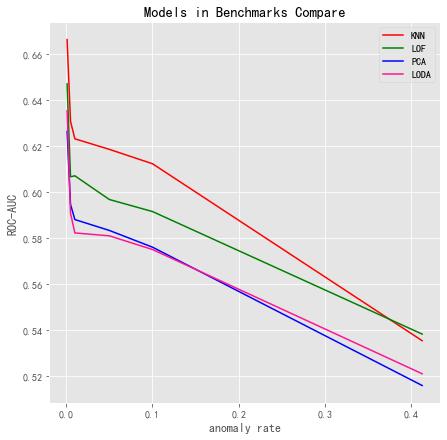

In [53]:
ar_mean.sort()
plt.figure(figsize=(7,7))
plt.xlabel('anomaly rate')
plt.ylabel('ROC-AUC')
colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
i = 0
for cls in classifiers:
    mean_y = [np.mean(results[cls][300:480]), np.mean(results[cls][480:670]), np.mean(results[cls][670:850]), 
              np.mean(results[cls][850:1030]), np.mean(results[cls][1030:1210]), np.mean(results[cls][:300]), ]    
    plt.plot(ar_mean, mean_y, color=colors[i], label=cls)
    i += 1
plt.title('Models in Benchmarks Compare')
plt.legend(loc="upper right")
plt.show()

### 有图可知，KNN和LOF在所有异常点比例下表现均不错，PCA和LODA在所有异常点比例下表现较差。